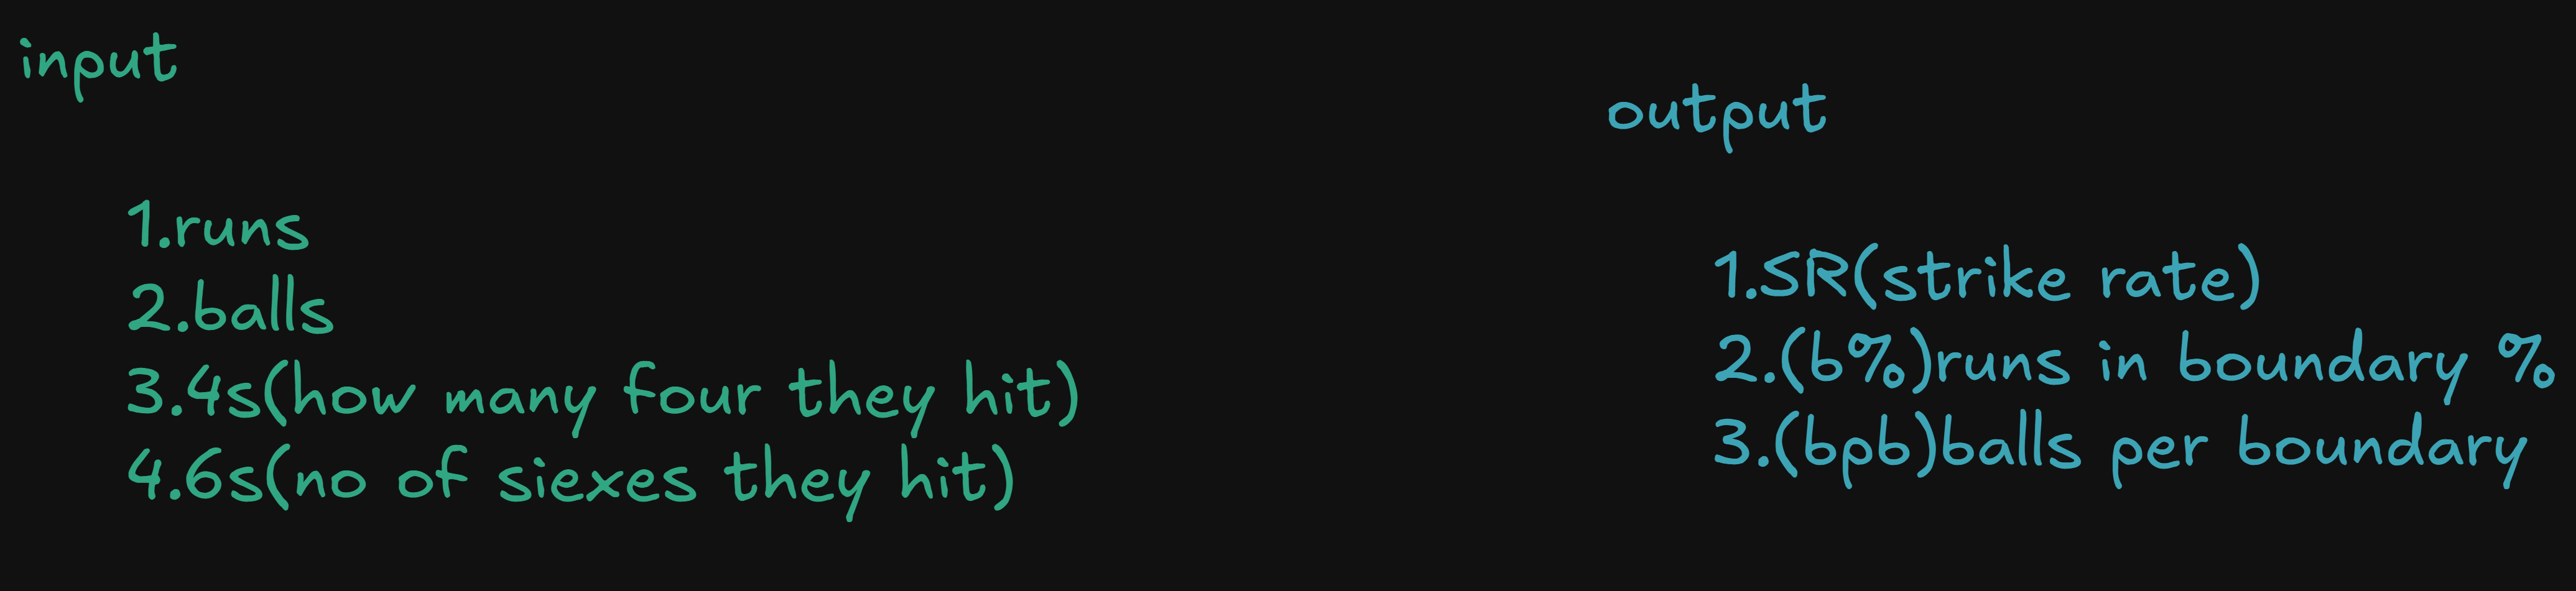

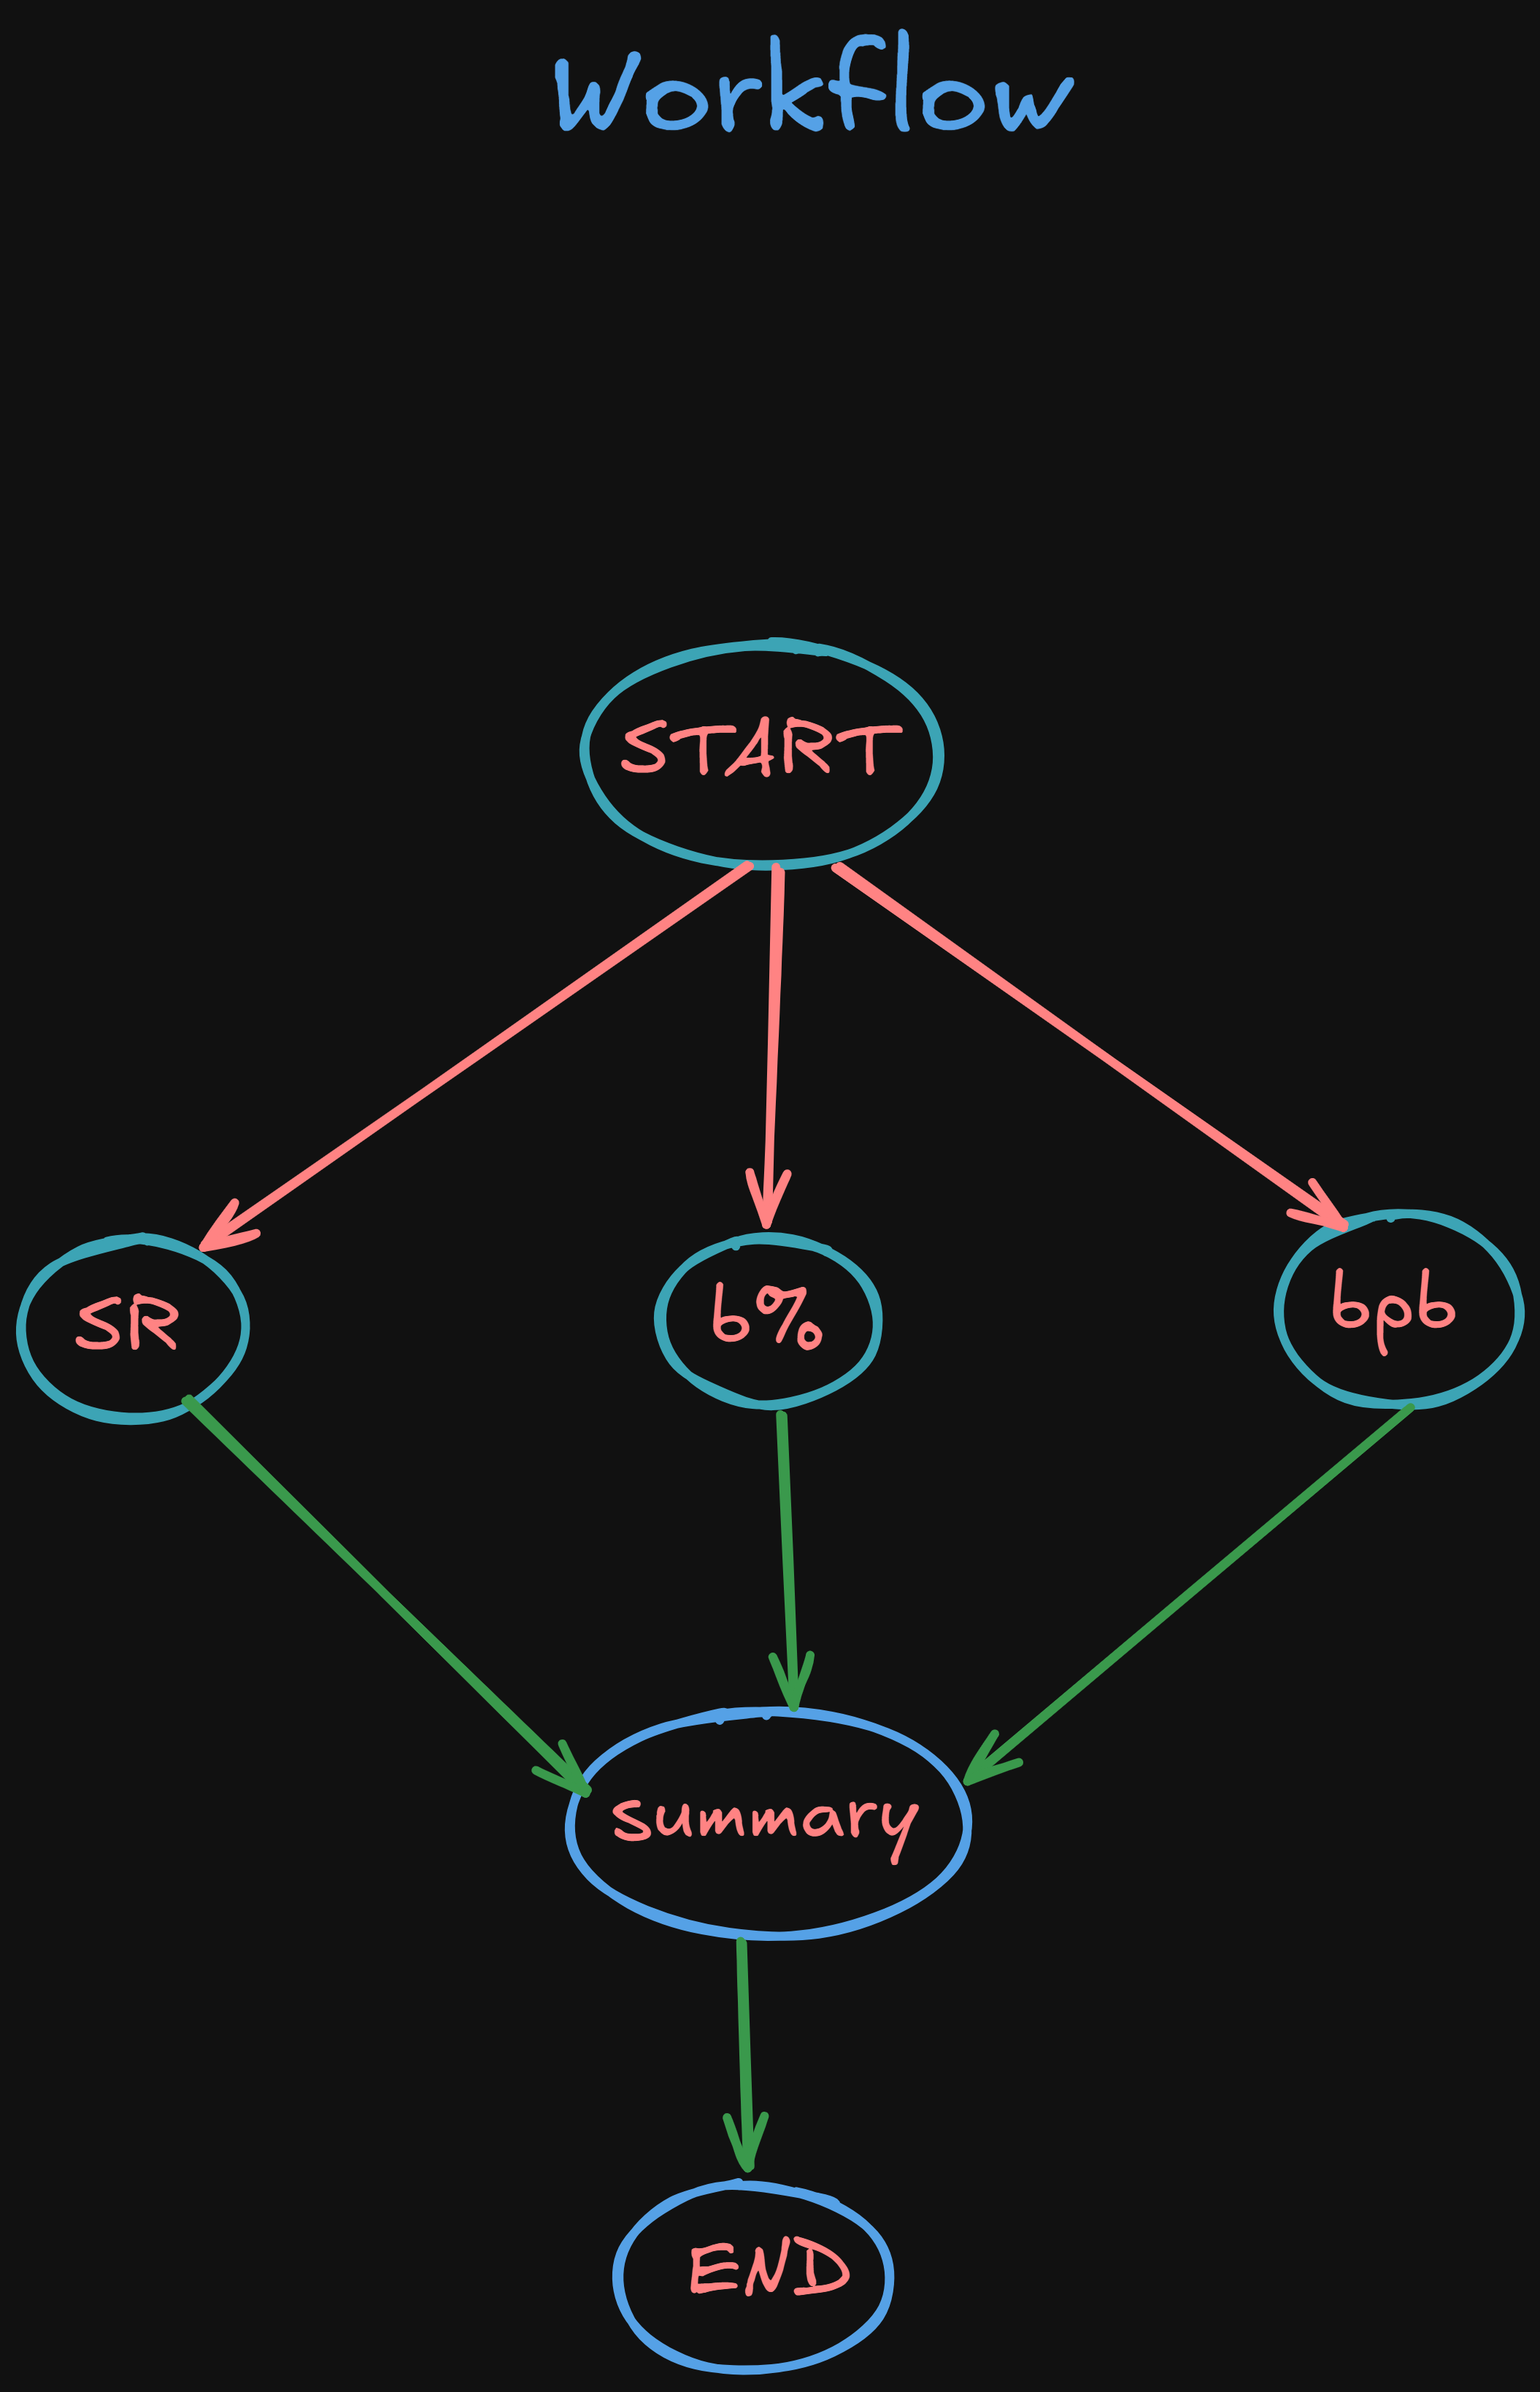

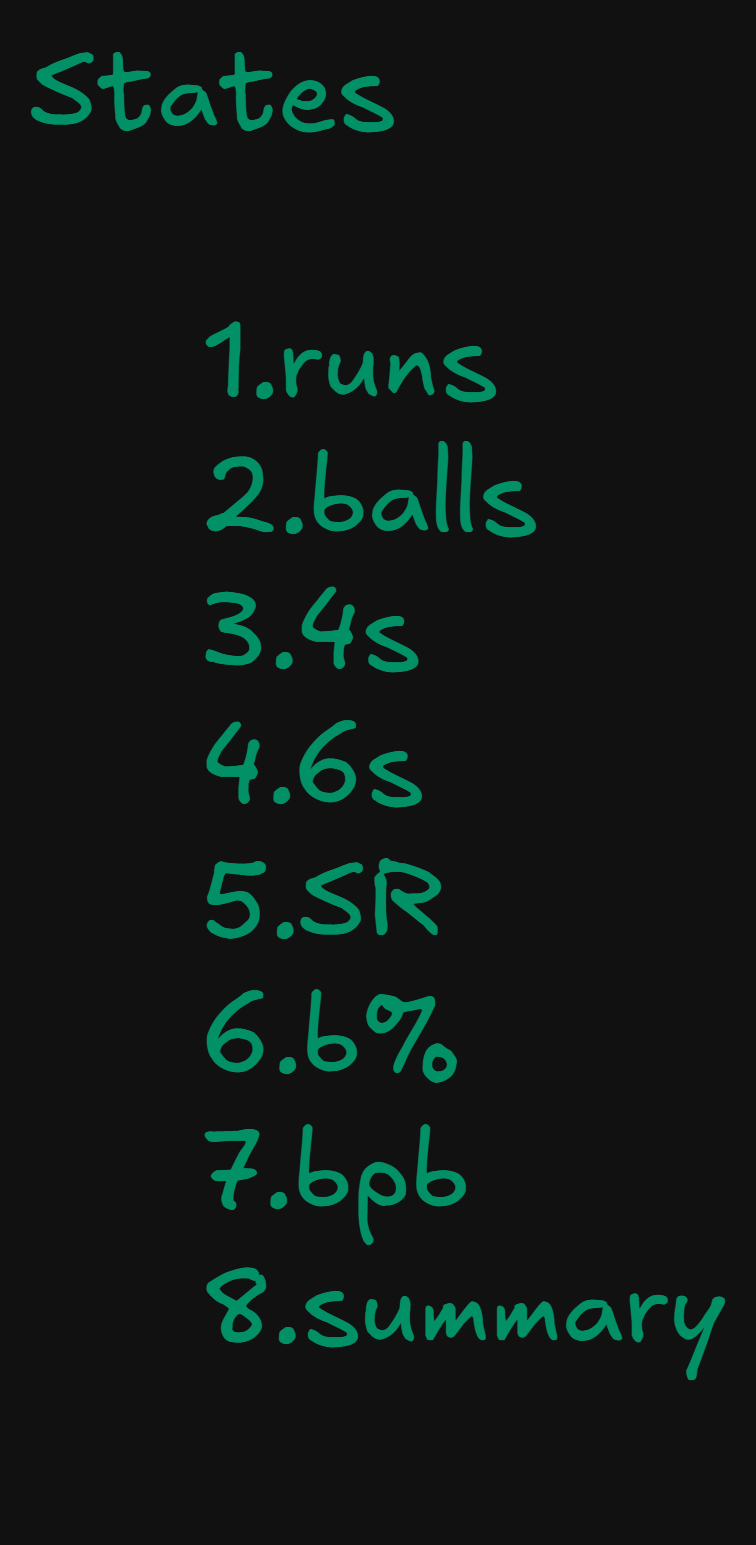

# <b> Step by Step 

Step1:-importing libraries

In [60]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict

step2:-creating state

In [61]:
class BatsmanState(TypedDict):

    # states that we have
    runs:int
    balls:int
    fours:int
    sixes:int

    # states that we will calucate
    sr:float
    bpb:float
    boundary_percent:float
    summary:str



step3:-initializing the graph

In [62]:
graph=StateGraph(BatsmanState)

step4:-adding nodes

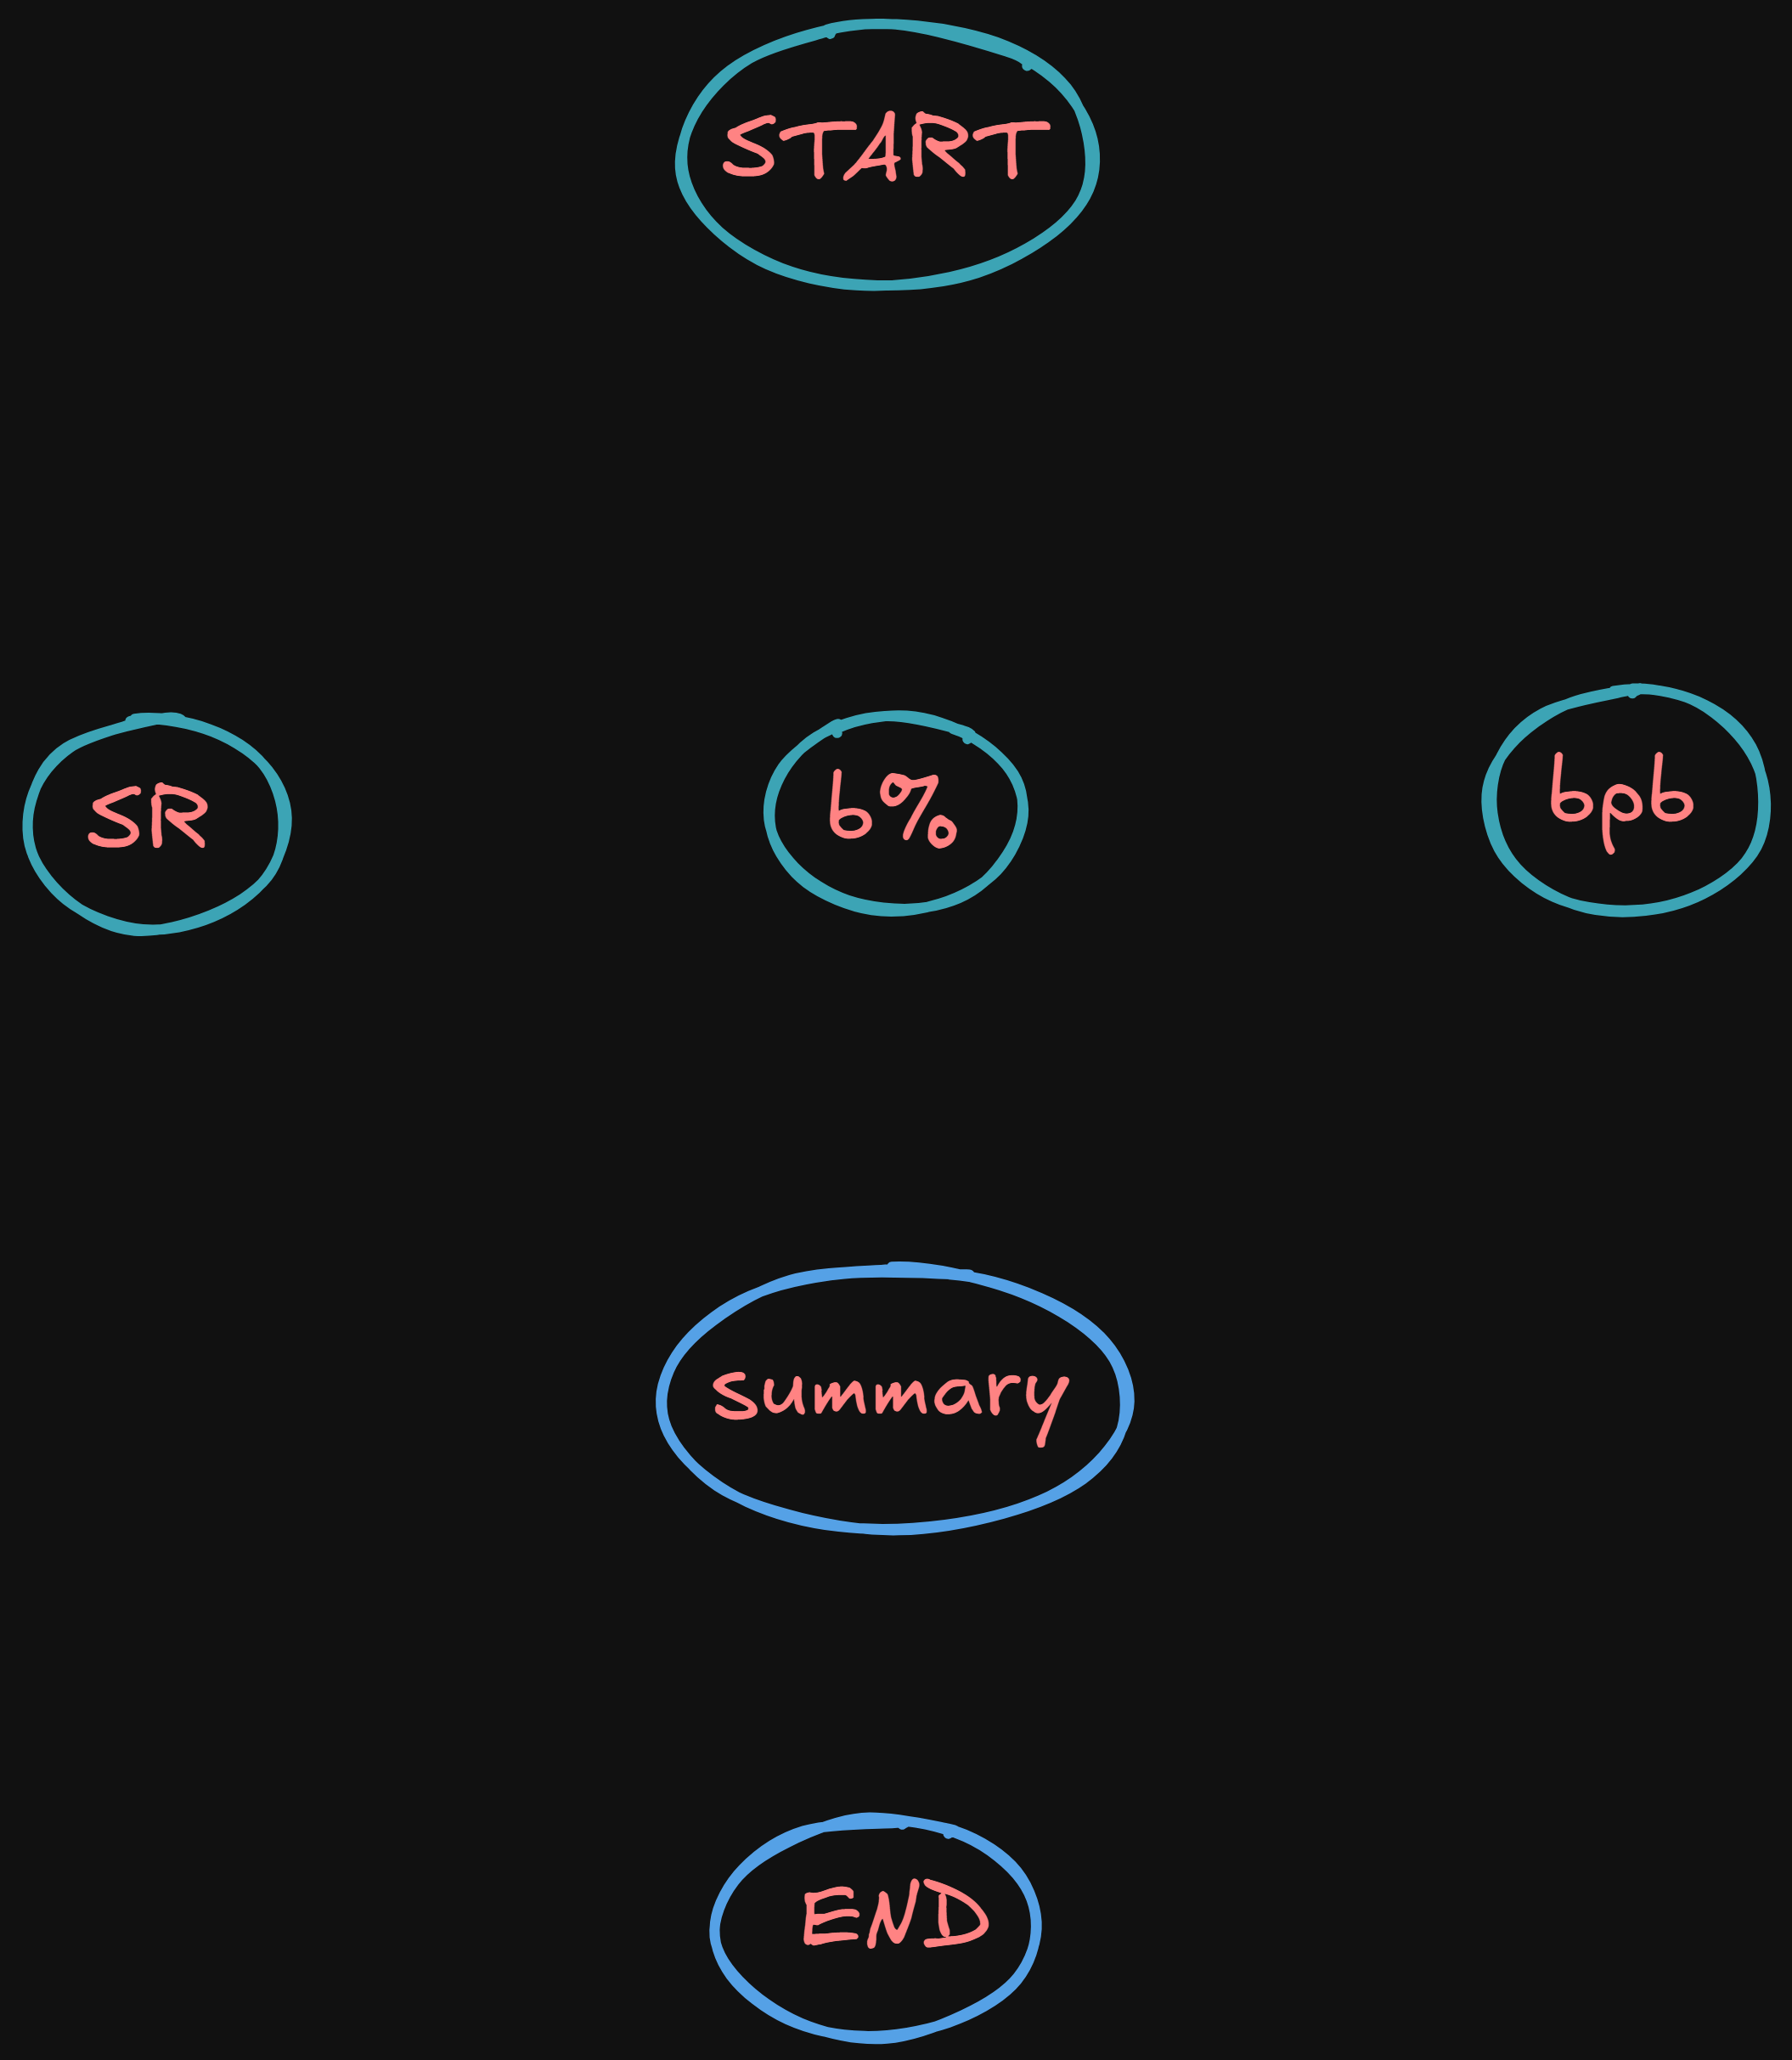

In [63]:
# calculating sr
def calculate_sr(state:BatsmanState):
    sr=(state['runs']/state['balls'])*100
    state['sr']=sr

    return state

In [64]:
# calculating bpb
def calculate_bpb(state:BatsmanState):
    bpb=state['balls']/(state['fours']+state['sixes'])
    state['bpb']=bpb
    return state

In [65]:
# calucalting boundary percent
def calculate_boundary_percent(state:BatsmanState):
    boundary_percent=(((state['fours']+state['sixes']))/state['runs'])*100
    state['boundary_percent']=boundary_percent

    return state

In [66]:
# creating summary
def summary(state:BatsmanState):
    summary=f"""    
Strike Rate={state['sr']}\n
Balls per boundary={state['bpb']}\ng
Boundary percent={state['boundary_percent']}

"""
    state['summary']=summary

    return state

In [67]:
graph.add_node('calculate_sr',calculate_sr)
graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calculate_boundary_percent',calculate_boundary_percent)
graph.add_node('summary',summary)


step5:-adding edges

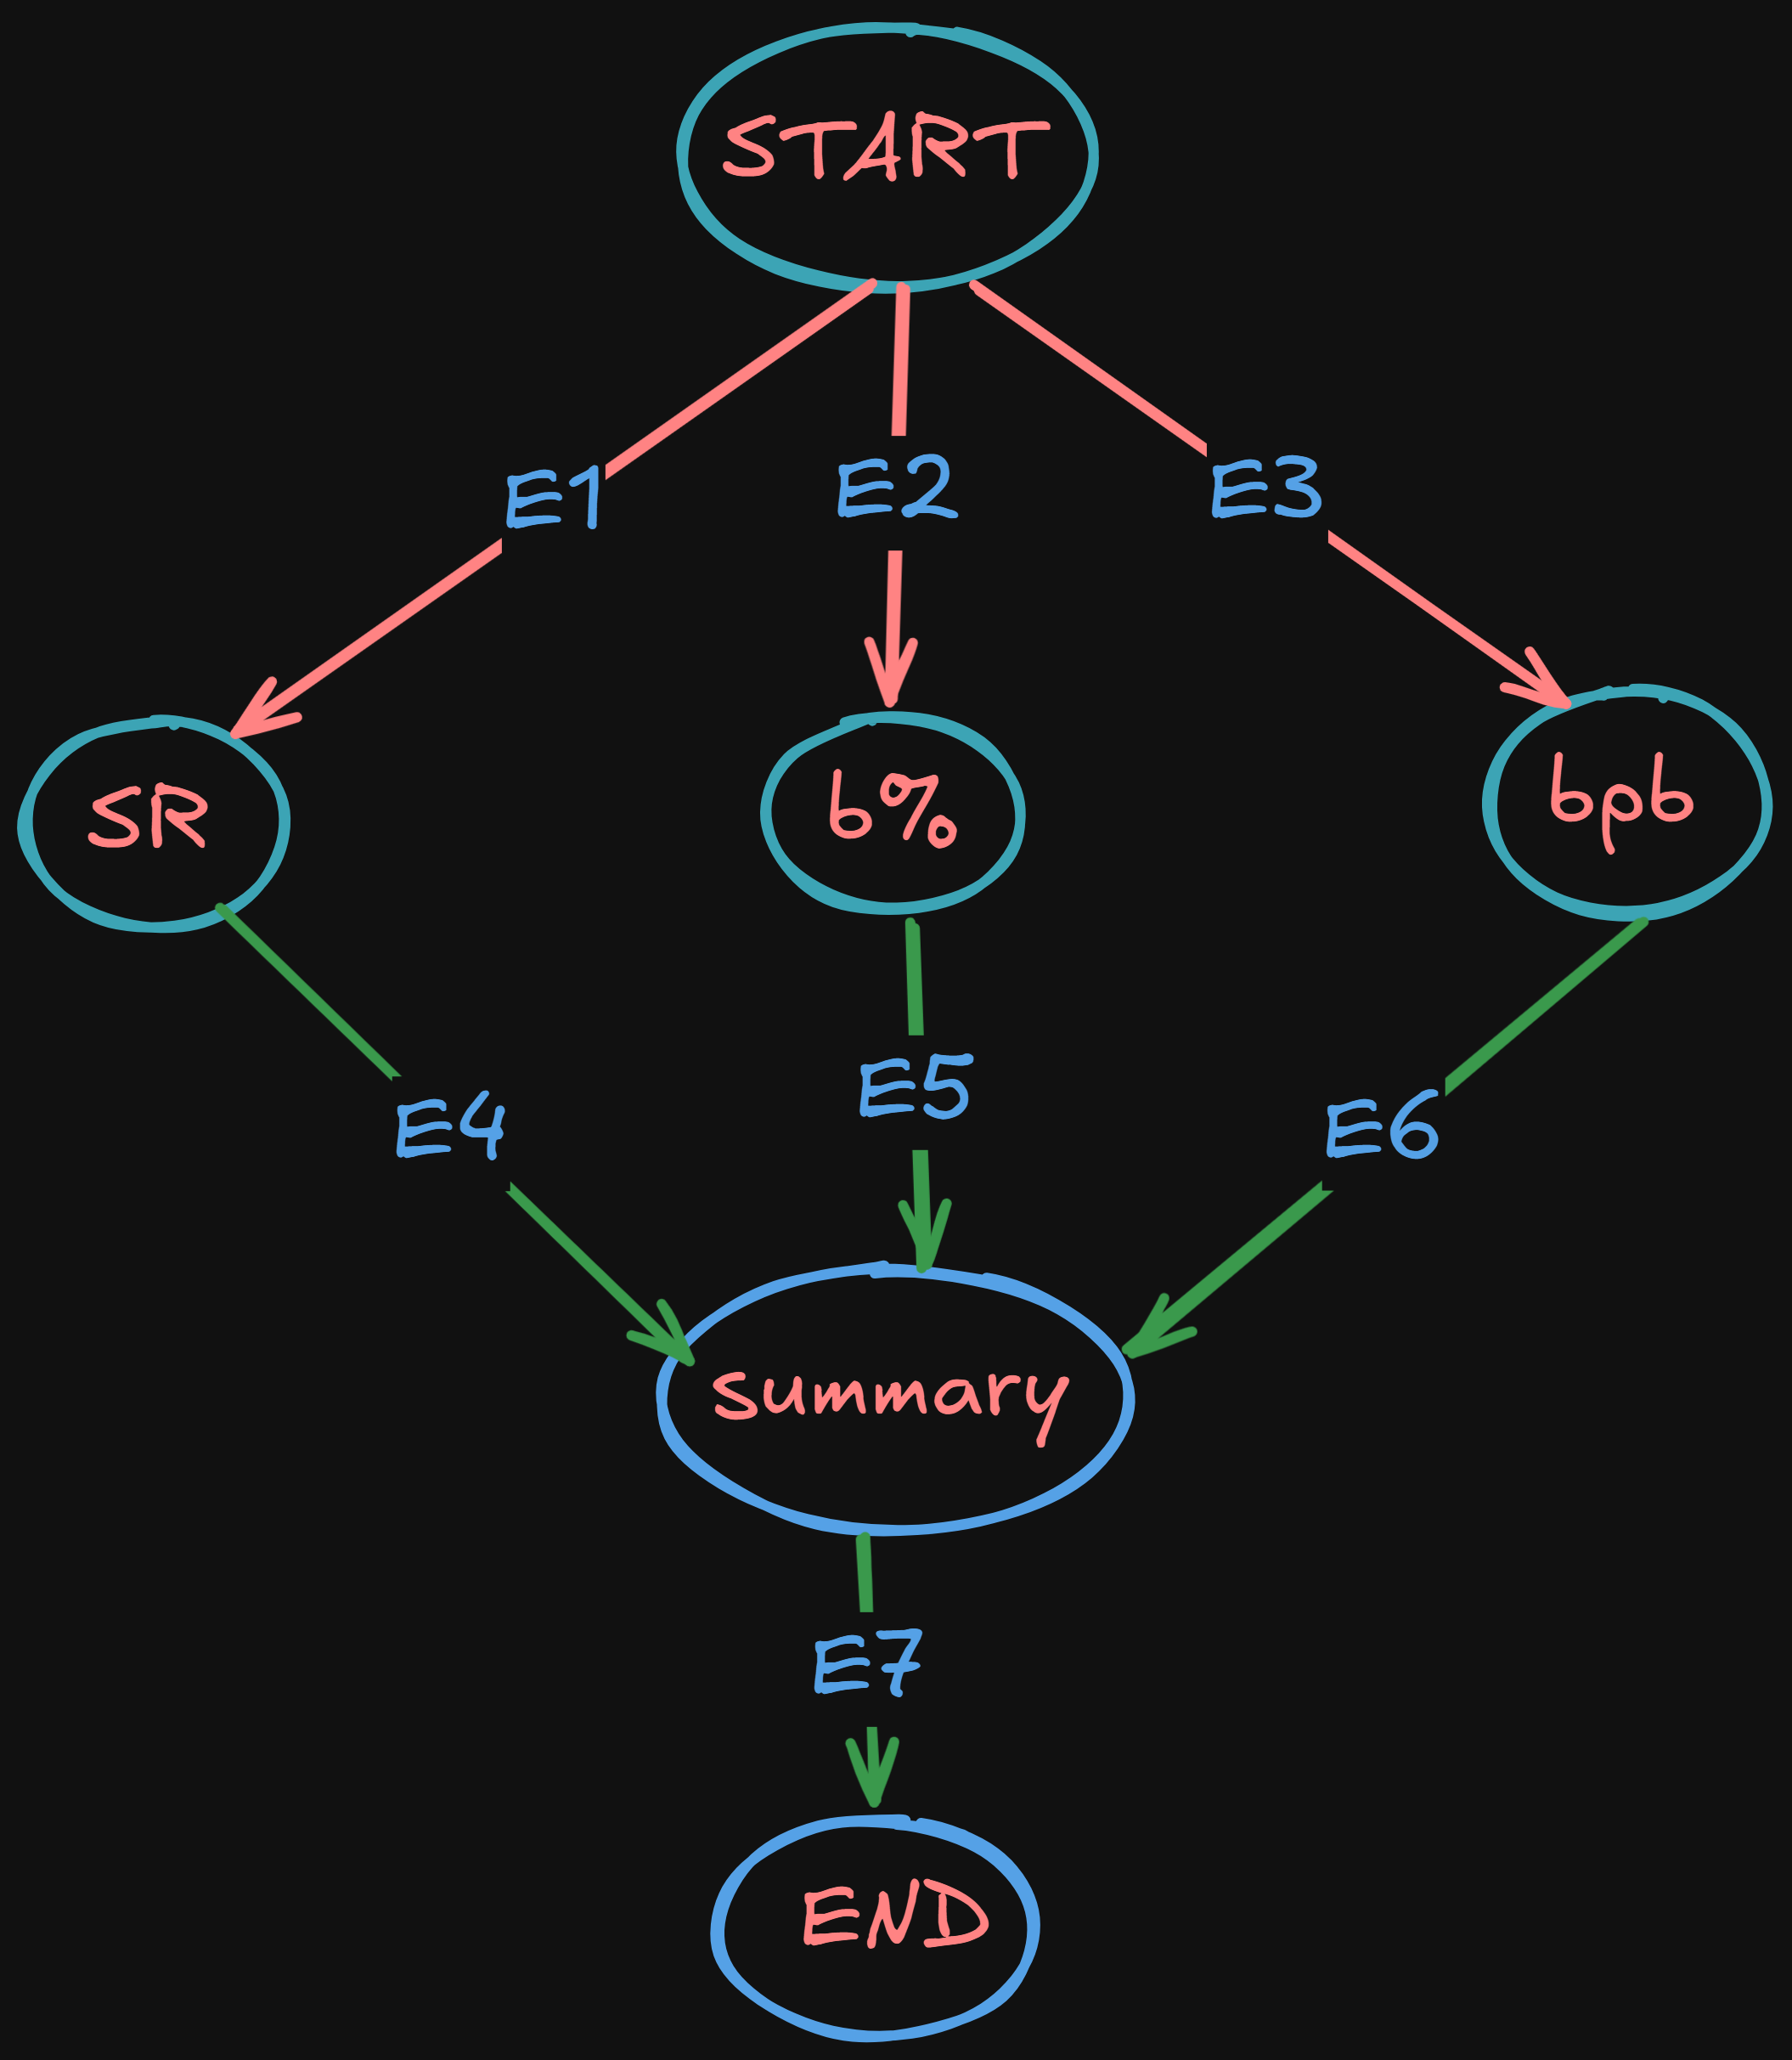

In [68]:
graph.add_edge(START,'calculate_sr')
graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calculate_boundary_percent')

graph.add_edge('calculate_sr','summary')
graph.add_edge('calculate_bpb','summary')
graph.add_edge('calculate_boundary_percent','summary')

graph.add_edge('summary',END)


step6:-compiling the graph

In [69]:
workflow=graph.compile()

step7:-visualizing the graph

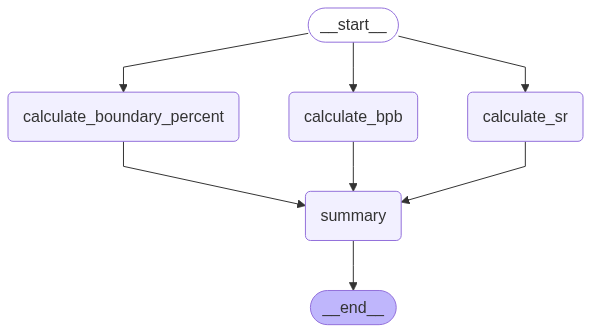

In [70]:
workflow

step8:-evaluating the graph

In [71]:
initial_state={
    'runs':100,
    'balls':50,
    'fours':6,
    'sixes':4
}

In [72]:
workflow.invoke(initial_state)

InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

The error you're encountering is:

```
vbnet
CopyEdit
InvalidUpdateError: At key 'runs': Can receive only one value per step. Use an Annotated key to handle multiple values.

```

This error comes from the **LangGraph** library (specifically its `LastValue` channel type) and it means:

---

### ❗️ Problem

Your graph **tried to write multiple values** to the same key (`'runs'`) **at the same time (i.e., during a single step)**.

LangGraph channels by default are of type `LastValue`, which can **only hold one value at a time per step**. If multiple nodes (or functions) write to the same key in the same tick/step, LangGraph raises an `InvalidUpdateError`.

---

### 🔧 Why It Happened

Suppose your state looks like this:

```python
python
CopyEdit
class MyState(TypedDict):
    runs: str

```

If **two nodes** in your graph both try to write something like:

```python
python
CopyEdit
return {"runs": "A"}  # from node A
return {"runs": "B"}  # from node B

```

...in the **same graph step**, then LangGraph doesn't know which one to keep, and throws this error.

---

### ✅ How to Fix It

### ✅ Option 1: Use `Annotated[...]` for `runs` to allow multiple values

If you **intend** for multiple nodes to write to the same key (`runs`), define your state using `Annotated` with `List[str]`, like this:

```python
python
CopyEdit
from typing import Annotated
from langgraph.channels import channel

class MyState(TypedDict):
    runs: Annotated[list[str], channel(type="gather")]

```

- This changes the behavior of `runs` to **accumulate multiple values**.
- The `"gather"` channel allows **many values per step**, unlike the default `"last_value"`.

---

### ✅ Option 2: Redesign so only one node writes to `'runs'` per step

If you're not expecting multiple writers, then:

- Check your graph structure and make sure only **one node** updates the `'runs'` key per tick.
- Use node dependencies (`edges`) to control write order or separation.

---

### 📚 Docs

You can read more about this error and how to fix it here:

👉 https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

---

### 🧠 Summary

- ✅ You tried to write multiple values to `'runs'` in one graph step.
- ❌ The default channel (`LastValue`) allows only one.
- 🔁 Either switch to `Annotated[..., channel(type="gather")]` or redesign your graph to prevent simultaneous writes.

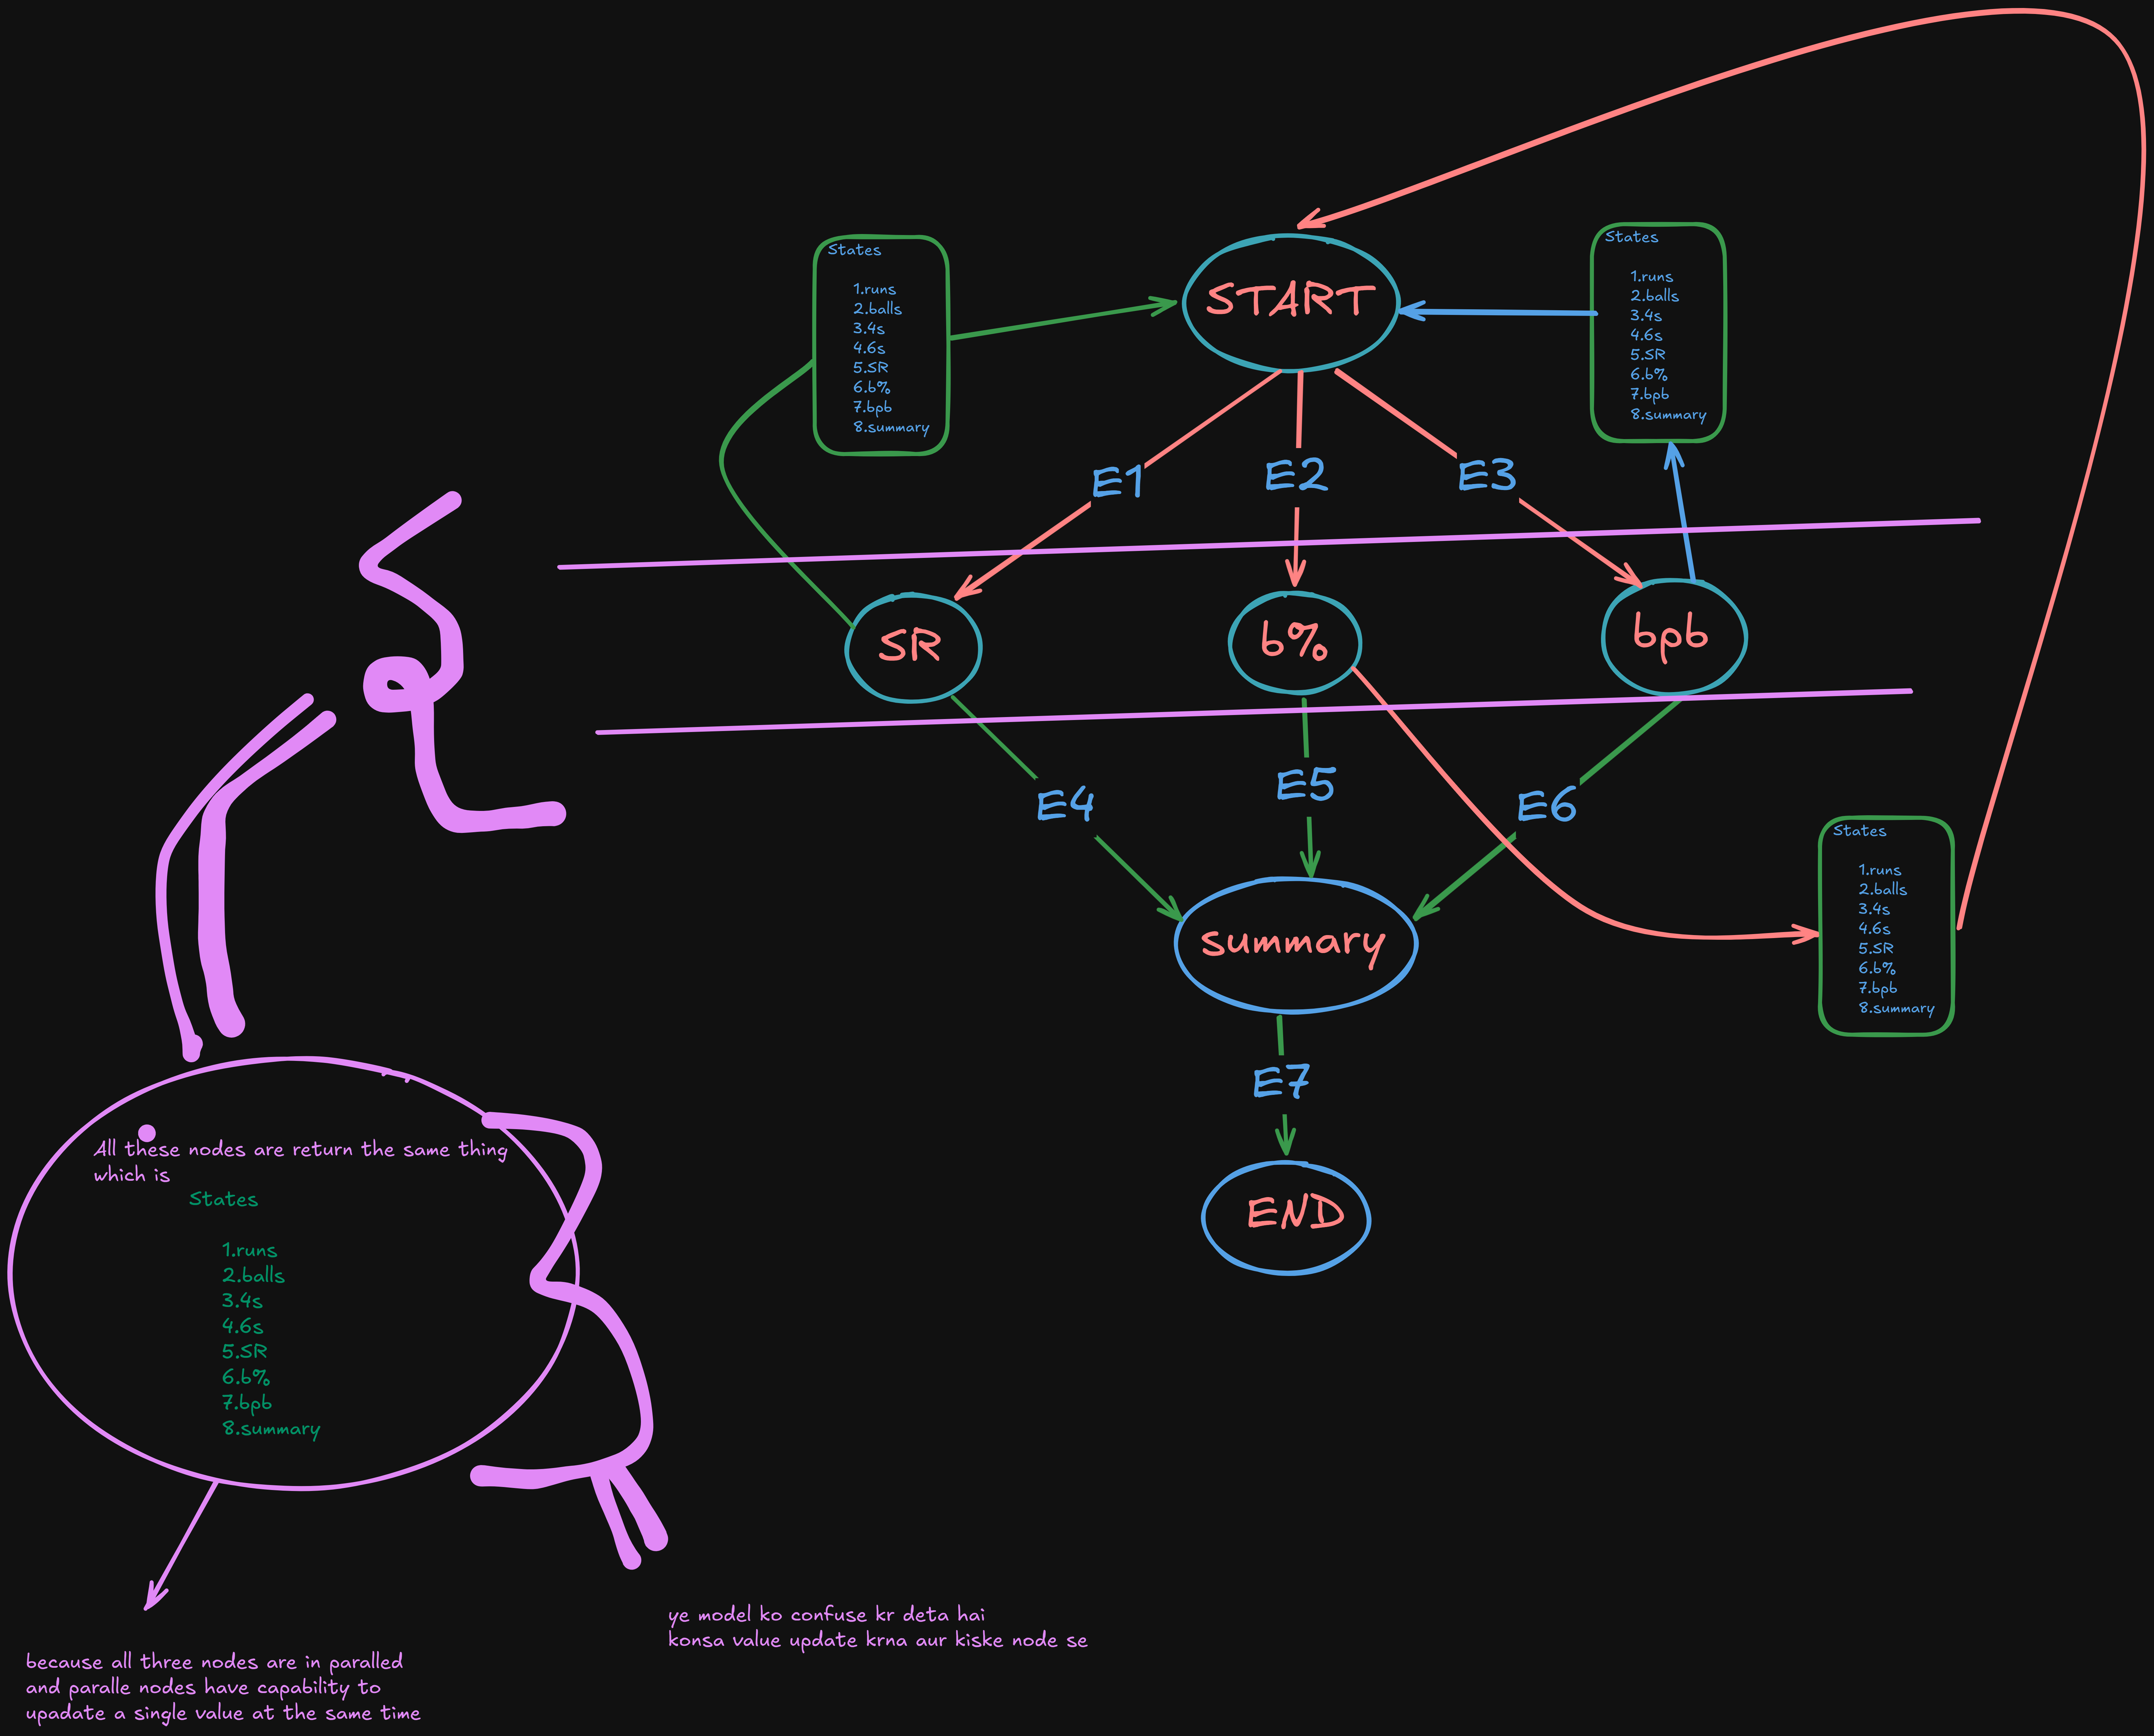

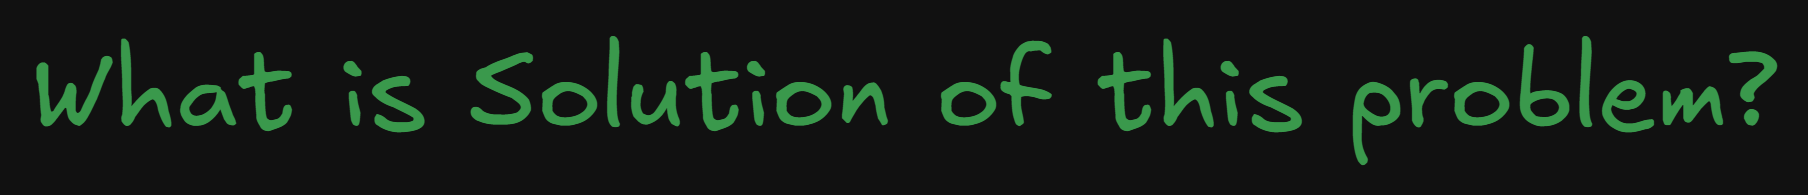